In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
my_colors = [u'#1f77b4',
 u'#ff7f0e',
 u'#2ca02c',
 u'#d62728',
 u'#9467bd',
 u'#8c564b',
 u'#e377c2',
 u'#7f7f7f',
 u'#bcbd22',
 u'#17becf',
 u'#f2f2f2',            
 u'#fffa00',
 u'#b6ff9b',
 u'#005400',
 u'#ffc28c',
 u'#d69c68',
 u'#c1c1c1',
 u'#fbccff',
 u'#ff5e5e',
 u'#00edb2',
 u'#ffca1e',
 u'#933f3f']
cutoff_per = 0.03
col = ['H1','L1','L2','H3','L3','H4','L4','H5','L5','Mix 1','Mix 2','Mix 3','Mix 4',"Gv Gi Gigi and Gc mix",
"Gc partial",
"PI 510757 high N Mead H3.",
"BSB mock R1",
"Bar code BSB mock R2",
"PI505735 mock R1",
"PI505735 mock R2",
"PI297155 mock R1",
"PI297155 mock R2",
"PI510757 mock R1",
"PI510757 mock R2",
" GRASSL mock R1",
"taxon","taxon_rm_UG"]
names  = !ls all_re_filtered_lensort_OTU_id*.uc
names = names[1:] + ["all_re_filtered_lensort_OTU_id100.uc"]
names[9]

'all_re_filtered_lensort_OTU_id100.uc'

# #Function: get OTU count table

In [2]:
def incorfiles(pwd):
    df = pd.read_csv(pwd,header=None,sep="\t")
    df1 = df[df[0]=="H"]
    dft = pd.DataFrame(df1.groupby(9).size())
    dft3 = dft[dft[0] > 2]
    dft3[0] = 1
    dft3 = dft3.reset_index()
    df2 = df1.iloc[:,-2:]
    df2[8] = ["_".join(a[0:2]) for a in list(df2[8].str.split("_"))]
    df2[10] = 1
    df3 = pd.DataFrame(df2.groupby([8,9])[10].sum())
    df3 = df3.reset_index()
    dfx = pd.merge(df3,dft3,left_on=9,right_on=9,how="left")
    dfy = dfx[dfx[0] > 0]
    dfy.columns = ["sample ID","OTU ID","count","sth"]
    dfy = dfy.iloc[:,:3]
    dftb = pd.pivot_table(dfy,index="OTU ID",columns="sample ID",values="count")
    return dftb


# #Function:get % tabble

In [3]:
def get_per_tb(pwd):
    df = incorfiles(pwd).T
    df['sort_1'] = [a[0] for a in df.index.str.split("st_|nd_")]
    df['sort_2'] = [a[1] for a in df.index.str.split("st_|nd_")]
    df = df.astype(float)
    df = df.sort_values(["sort_1","sort_2"])
    df = df.iloc[:,:-2].T
    df['sort'] = [a[1] for a in df.index.str.split("_")]
    df = df.sort_values(["sort"])
    df = df.iloc[:,:-1]
    df_per = df/df.sum()
    #df_per = df_per[df_per > cutoff_per] # filter low percentage of OTU
    return df_per
#get_per_tb(names[6])


# #Function:get taxon columns

In [4]:
def tax_genus(pwd):
    tax1 = pd.read_csv(pwd,header=None,sep="\t",index_col=0)
    tax1 = pd.DataFrame(tax1.loc[:,1])
    tax1 = tax1[1].str.split(",",expand=True)
    for i in list(tax1.columns):
        tax1[i] = tax1[i].replace(".+unidentified.+",np.nan,regex=True)
    #tax1[tax1[5] == "None"]
    #tax1[tax1[5].isnull()]
    tax1["taxon"] = ""
    for i in tax1.columns[:-2]:
        add_tax = ~tax1.iloc[:,i].isnull()
        tax1.iloc[:,-1][add_tax] = tax1[add_tax].iloc[:,i]
        tax2 = pd.DataFrame(tax1.iloc[:,-1].str.split("(",expand=True)[0])
        tax2.columns = ["taxon"]
    return tax2
#tax_genus("all_re_filtered_lensort_OTU_id100_sintax_rm.txt")

# #Function:get per and taxon table

In [10]:
def get_per_taxon_tb(eachTestID):
    tax = tax_genus(eachTestID.replace(".uc","_sintax_rm.txt"))
    tax.columns = ["taxon_unite"]
    tax_rm_Ug = tax_genus(eachTestID.replace(".uc","_sintax_rm_unidentifiedG.txt"))
    tax_rm_Ug.columns = ["taxon_unite_rmUg"]
    df_per = pd.merge(get_per_tb(eachTestID),tax,left_index=True,right_index=True,how="left")
    df_per = pd.merge(df_per,tax_rm_Ug,left_index=True,right_index=True,how="left")
    try:
        del df_per["2nd_1"]
    except Exception:
        pass
    try:
        del df_per["2nd_14"]
    except Exception:
        pass
    
    df_per.columns = col
    df_per["taxon_rm_UG"] = df_per["taxon_rm_UG"].str.replace("g:Claroideoglomus","Gc").str.replace("g:Rhizophagus","Ri").str.replace("g:Diversispora","Gv").str.replace("g:Gigaspora","Gigi") #simplify the taxon to Gv, Gigi, Ri and Gc

    return df_per


# #Function: extract_known_samples_taxon table

In [11]:
def extract_known_samples_taxon(eachTestID):
    df = get_per_taxon_tb(eachTestID)
    col_known = ['H3','Mix 1','Mix 2', 'Mix 3', 'Mix 4', 'Gv Gi Gigi and Gc mix', 'Gc partial','PI 510757 high N Mead H3.','taxon','taxon_rm_UG']
    df = df.loc[:,col_known]
    df = df.loc[df.iloc[:,:7].dropna(how='all').index,:]
    return df



In [12]:
def plot_known_samples(eachTestID):
    df = extract_known_samples_taxon(eachTestID)
    df.iloc[:,:-2].T.plot(kind='bar', stacked=True,colors=my_colors,figsize=(4,4))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 4})
    plt.xticks(rotation=90)
    plt.xlabel('sample ID')
    plt.ylabel('Abundance')
    plt.plot( [4.5,4.5],[0,1.02],linestyle='-',color='k')
    plt.text(4.8, 1.01, "2nd PacBio run") 
    plt.text(1, 1.01, "1st PacBio run") 
    for j in np.arange(0,8):
        dft = df.iloc[:,[j,-1]].dropna()
        a = list(dft.iloc[:,0])
        b =[]
        dft1 = dft.copy()
        for i in np.arange(1,len(a)+1):
            b.append(sum(a[:i]))
        dft1.iloc[:,0] = b
        #dft.set_index('taxon_rm_UG')
        ind = list(dft[dft.iloc[:,0] > 0.05].index)
        dft2 = dft1.loc[ind,:]
        for y, label in zip(list(dft2.iloc[:,0]),list(dft2.iloc[:,1])):
            plt.text(j-0.5, y-0.02, label,fontsize=8,rotation='vertical')
    plt.title("OTUs clustering > 5 passes " + eachTestID.replace(".uc","%_identity").replace("all_re_filtered_lensort_OTU_",""))
    return plt.savefig(eachTestID.replace("all_re_filtered_lensort_OTU_","usearch_clustering_").replace(".uc","") + "_plot.png", bbox_inches='tight')

In [13]:
names[0]

'all_re_filtered_lensort_OTU_id91.uc'

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: Length mismatch: Expected axis has 26 elements, new values have 27 elements

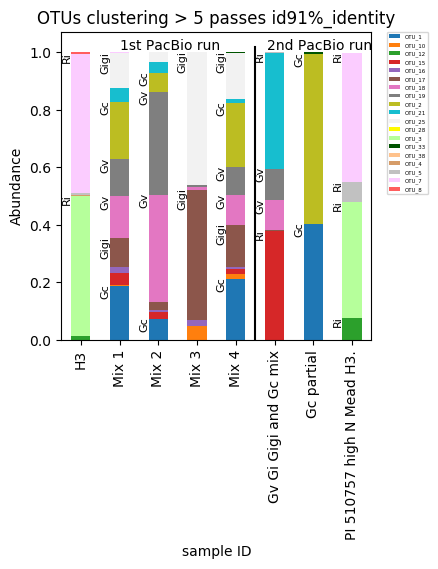

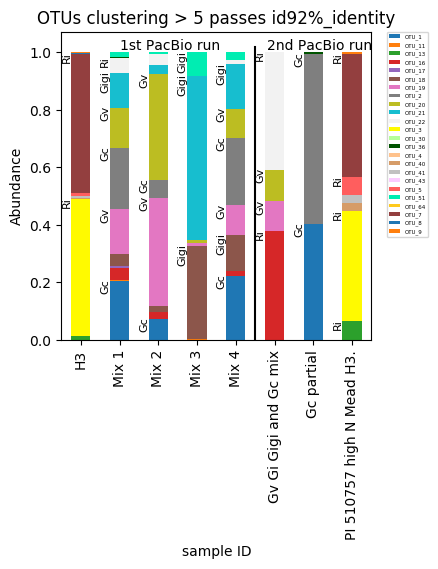

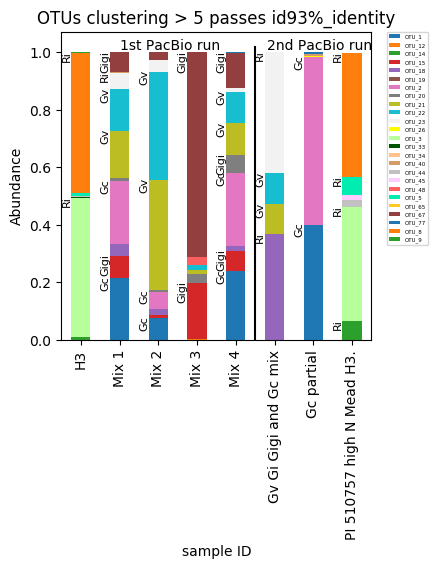

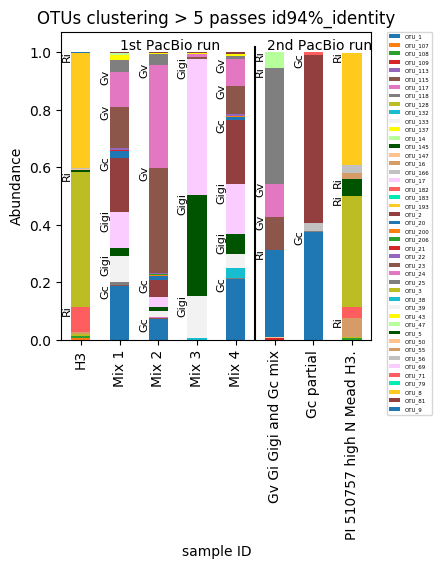

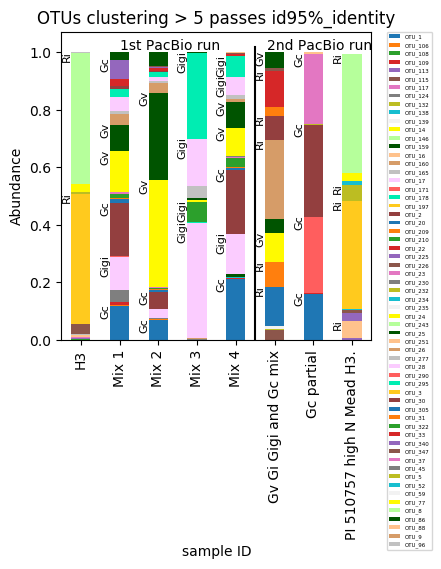

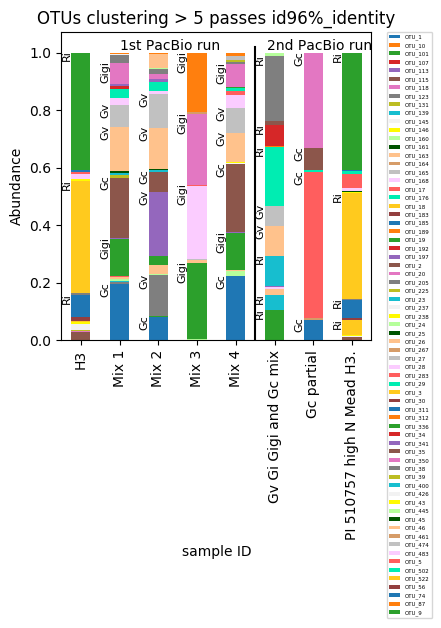

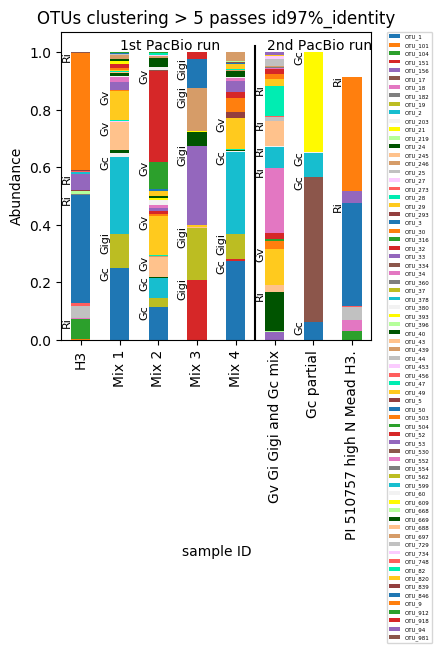

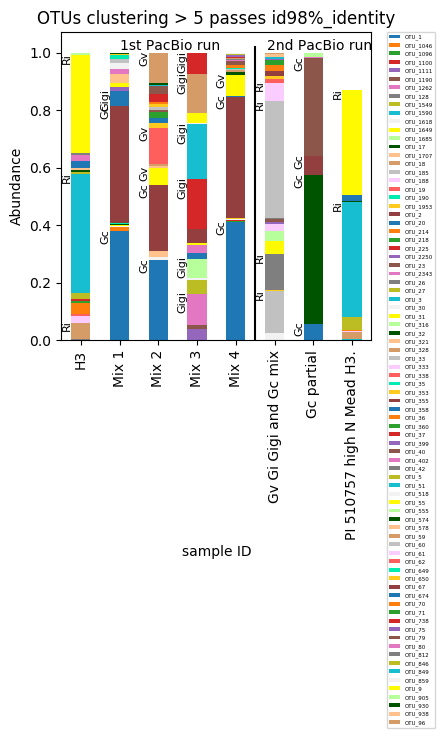

In [14]:
plot_known_samples(names[0])
plot_known_samples(names[1])
plot_known_samples(names[2])
plot_known_samples(names[3])
plot_known_samples(names[4])
plot_known_samples(names[5])
plot_known_samples(names[6])
plot_known_samples(names[7])